In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.13.0
pandas==2.0.3
numpy==1.23.1
matplotlib==3.5.3


In [3]:
df = pd.read_csv('ATVI_all.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volumn
0,2021/10/18,76.139999,76.720001,75.239998,75.137978,75.137978,5417407
1,2021/10/19,76.769997,77.199997,75.949997,75.905098,75.905098,4238549
2,2021/10/20,77.519997,78.080002,77.081001,76.790230,76.790230,4537908
3,2021/10/21,77.720001,78.739998,76.720100,77.399986,77.399986,5904311
4,2021/10/22,78.620003,80.919998,78.620003,77.960564,77.960564,6960407


In [4]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [5]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [6]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 100000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 0.390958
iter 20. reward: 0.335530
iter 30. reward: 0.518631
iter 40. reward: 0.562127
iter 50. reward: 0.561292
iter 60. reward: 0.681684
iter 70. reward: 0.637289
iter 80. reward: 0.695606
iter 90. reward: 0.736912
iter 100. reward: 0.825755
iter 110. reward: 0.796149
iter 120. reward: 0.868191
iter 130. reward: 1.051173
iter 140. reward: 0.963285
iter 150. reward: 0.989805
iter 160. reward: 0.934974
iter 170. reward: 1.043127
iter 180. reward: 1.180548
iter 190. reward: 1.294711
iter 200. reward: 1.108853
iter 210. reward: 1.409802
iter 220. reward: 0.913438
iter 230. reward: 1.321281
iter 240. reward: 1.323371
iter 250. reward: 1.312932
iter 260. reward: 1.347219
iter 270. reward: 1.407758
iter 280. reward: 1.412361
iter 290. reward: 1.363524
iter 300. reward: 1.504709
iter 310. reward: 1.366948
iter 320. reward: 1.405585
iter 330. reward: 1.417484
iter 340. reward: 1.572895
iter 350. reward: 1.287213
iter 360. reward: 1.348774
iter 370. reward: 1.317706
iter 380. 

In [7]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 9: buy 1 unit at price 76.898415, total balance 99923.101585
day 10: buy 1 unit at price 78.039246, total balance 99845.062340
day 11, sell 1 unit at price 76.387001, investment -0.665051 %, total balance 99921.449341,
day 12: buy 1 unit at price 65.647385, total balance 99855.801956
day 13: buy 1 unit at price 67.102943, total balance 99788.699013
day 14: buy 1 unit at price 66.709549, total balance 99721.989464
day 15: buy 1 unit at price 65.716225, total balance 99656.273239
day 16: buy 1 unit at price 65.991600, total balance 99590.281639
day 18: buy 1 unit at price 66.384995, total balance 99523.896645
day 21: buy 1 unit at price 65.047462, total balance 99458.849182
day 23: buy 1 unit at price 61.634777, total balance 99397.214405
day 24: buy 1 unit at price 61.349571, total balance 99335.864834
day 25: buy 1 unit at price 61.172543, total balance 99274.692291
day 26: buy 1 unit at price 60.749645, total balance 99213.942646
day 27: buy 1 unit at price 59.903851, total balanc

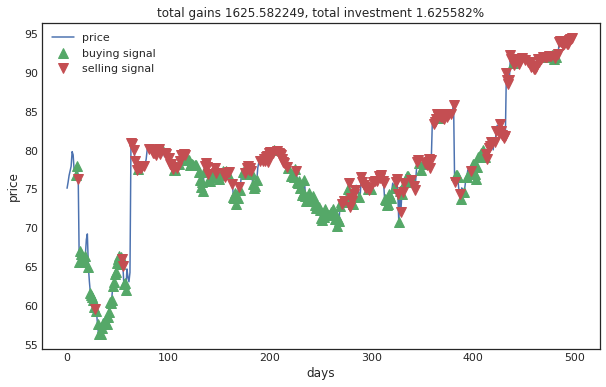

In [10]:
fig = plt.figure(figsize = (10, 6))
plt.style.use('seaborn-white')
plt.plot(close, label='price')
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()